# ColorFool tutorial
This is the tutorial repository of **ColorFool: Semantic Adversarial Colorization**, a work published in The IEEE Conference on Computer Vision and Pattern Recognition (**CVPR**), Seattle, Washington, USA, 14-19 June, **2020**.

Paper: https://openaccess.thecvf.com/content_CVPR_2020/papers/Shamsabadi_ColorFool_Semantic_Adversarial_Colorization_CVPR_2020_paper.pdf

Full implementation: https://github.com/smartcameras/ColorFool

Video: https://www.youtube.com/watch?v=fGw1ZiqOrWo

Tweet: https://twitter.com/AliShahinShams1/status/1250369697276715008?s=20

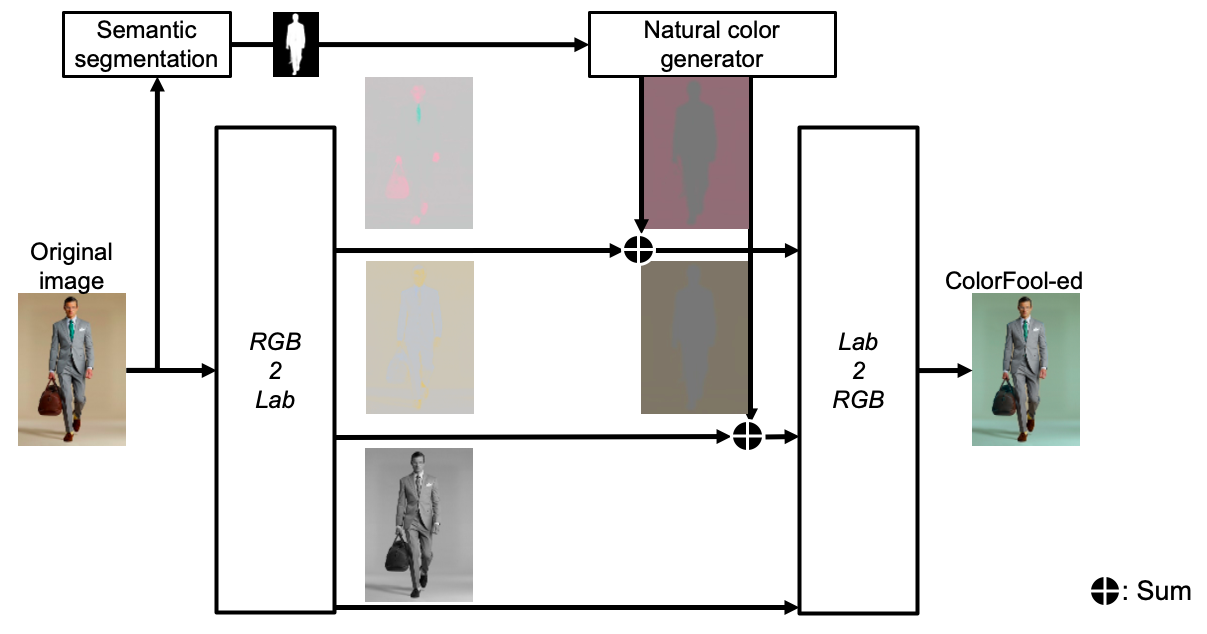





# Import required libraries

In [1]:
import cv2
from matplotlib import pyplot as plt
from torchvision import models
import numpy as np
import torchvision.transforms as T
from torch.nn import functional as F
from skimage import color
from copy import copy as copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Prepare an image and semantic regions within it

Paths to the image and binary masks

In [ ]:
image_path = '/content/drive/My Drive/TutorialColorFool/Image/ILSVRC2012_val_00003533.JPEG'
person_mask_path = '/content/drive/My Drive/TutorialColorFool/Masks/Person/ILSVRC2012_val_00003533.JPEG'
sky_mask_path = '/content/drive/My Drive/TutorialColorFool/Masks/Sky/ILSVRC2012_val_00003533.JPEG' 
water_mask_path = '/content/drive/My Drive/TutorialColorFool/Masks/Water/ILSVRC2012_val_00003533.JPEG'
vegetation_mask_path = '/content/drive/My Drive/TutorialColorFool/Masks/Vegetation/ILSVRC2012_val_00003533.JPEG'

Load the original image with its four corresponding masks 

In [ ]:
original_image = cv2.imread(image_path, 1)
person_mask = cv2.imread(person_mask_path)
water_mask = cv2.imread(water_mask_path)
vegetation_mask = cv2.imread(vegetation_mask_path) 
sky_mask = cv2.imread(sky_mask_path) 


Show the image and masks


In [ ]:
plt.rcParams["figure.figsize"] = (20,5)
figure, axs = plt.subplots(1, 5)

axs[0].set_title('Original image')
axs[0].imshow(original_image[:, :, (2, 1, 0)])
axs[0].set_axis_off()

axs[1].set_title('Person regions')
axs[1].imshow(person_mask)
axs[1].set_axis_off()

axs[2].set_title('Water regions')
axs[2].imshow(water_mask)
axs[2].set_axis_off()

axs[3].set_title('Vegetation regions')
axs[3].imshow(vegetation_mask)
axs[3].set_axis_off()

axs[4].set_title('Sky regions')
axs[4].imshow(sky_mask)
axs[4].set_axis_off()

plt.show()

# Predict the class of the original image

The model recieves RGB images of size 224x224x3 that are normalised using mean and std

In [ ]:
original_image = original_image[:, :, (2, 1, 0)]
image = cv2.resize(original_image, (224, 224), interpolation=cv2.INTER_LINEAR)

mean = np.asarray([ 0.485, 0.456, 0.406 ])
std = np.asarray([ 0.229, 0.224, 0.225 ])
trf = T.Compose([T.ToPILImage(),
  T.ToTensor(),
  T.Normalize(mean=mean, std=std)])

Load the target model under attack

In [ ]:
model = models.alexnet(pretrained=True)
model.eval()
model.to('cuda')

Feed the image to the model and predict logit scores, probabilities and class

In [ ]:
logit = model.forward(trf(image).cuda().unsqueeze_(0))
h_x = F.softmax(logit,dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)

probs = np.array(probs.cpu())
idx = np.array(idx.cpu())
  
org_class= idx[0]
org_class_prob = probs[0]
print('The class of the original image is {}' .format(org_class))

Check the corresponding class at https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a


# Generate the ColorFool-ed adversarial image

Transfer the original image from the RGB to the Lab color space ans set number of maximum number of trials

In [ ]:
original_image_lab=color.rgb2lab(original_image)
maxTrials = 1000
water_mask=water_mask[:,:,0]/255.
person_mask=person_mask[:,:,0]/255.
sky_mask=sky_mask[:,:,0]/255.
vegetation_mask=vegetation_mask[:,:,0]/255.

Change the colour randomly until mislead the model

In [ ]:
for trial in range(maxTrials): 
  
  X_lab = original_image_lab.copy()
  
  margin = 127
  mult = float(trial+1) / float(maxTrials) 

  # Adversarial color perturbation for Water regions
  water_mask_binary = copy(water_mask)
  water_mask_binary[water_mask_binary>0] = 1
  water = X_lab[water_mask_binary == 1]
  if water.size != 0:
    a_min = water[:,1].min()
    a_max = np.clip(water[:,1].max(), a_min=None, a_max = 0)
    b_min = water[:,2].min()
    b_max = np.clip(water[:,2].max(), a_min=None, a_max = 0)
    a_blue = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-margin-a_min), mult*(-a_max), size=(1))) * water_mask
    b_blue = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-margin-b_min), mult*(-b_max), size=(1))) * water_mask
  else:
    a_blue = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)
    b_blue = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)

  # Adversarial color perturbation for Vegetation regions
  vegetation_mask_binary = copy(vegetation_mask)
  vegetation_mask_binary[vegetation_mask_binary>0] = 1
  green = X_lab[vegetation_mask_binary == 1]
  if green.size != 0:
    a_min = green[:,1].min()
    a_max = np.clip(green[:,1].max(), a_min=None, a_max = 0)
    b_min = np.clip(green[:,2].min(), a_min=0, a_max = None)
    b_max = green[:,2].max()
    a_green = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-margin-a_min), mult*(-a_max), size=(1))) * vegetation_mask
    b_green = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-b_min), mult*(margin-b_max), size=(1))) * vegetation_mask
  else:
    a_green = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)
    b_green = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)
  
  # Adversarial color perturbation for Sky regions
  sky_mask_binary = copy(sky_mask)
  sky_mask_binary[sky_mask_binary>0] = 1
  sky = X_lab[sky_mask_binary == 1]
  if sky.size != 0:
    a_min = sky[:,1].min()
    a_max = np.clip(sky[:,1].max(), a_min=None, a_max = 0)
    b_min = sky[:,2].min()
    b_max = np.clip(sky[:,2].max(), a_min=None, a_max = 0)
    a_sky = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-margin-a_min), mult*(-a_max), size=(1))) * sky_mask
    b_sky = np.full((X_lab.shape[0], X_lab.shape[1]), np.random.uniform(mult*(-margin-b_min), mult*(-b_max), size=(1))) * sky_mask
  else:
    a_sky = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)
    b_sky = np.full((X_lab.shape[0], X_lab.shape[1]), 0.)


  mask = (person_mask + water_mask + vegetation_mask + sky_mask) 
  mask[mask>1] = 1

  # Smooth boundaries between sensitive regions
  kernel = np.ones((5, 5), np.uint8)
  mask = cv2.blur(mask,(10,10))

  # Adversarial color perturbation for non-sensitive regions
  random_mask = 1 - mask
  a_random = np.full((X_lab.shape[0],X_lab.shape[1]), np.random.uniform(mult*(-margin), mult*(margin), size=(1)))
  b_random = np.full((X_lab.shape[0],X_lab.shape[1]), np.random.uniform(mult*(-margin), mult*(margin), size=(1)))
  a_random_mask = a_random * random_mask
  b_random_mask = b_random * random_mask 
  

  # Adversarialy perturb color (i.e. a and b channels in the Lab color space) of the clean image 
  noise_mask = np.zeros((X_lab.shape), dtype=float)
  noise_mask[:,:,1] = a_blue + a_green + a_sky + a_random_mask
  noise_mask[:,:,2] = b_blue + b_green + b_sky + b_random_mask		
  X_lab_mask = np.zeros((X_lab.shape), dtype=float)
  X_lab_mask [:,:,0] = X_lab [:,:,0]
  X_lab_mask [:,:,1] = np.clip(X_lab [:,:,1] + noise_mask[:,:,1], -margin, margin)
  X_lab_mask [:,:,2] = np.clip(X_lab [:,:,2] + noise_mask[:,:,2], -margin, margin)
  
  # Transfer from LAB to RGB
  X_rgb_mask = np.uint8(color.lab2rgb(X_lab_mask)*255.)

  # Predict the label of the adversarial image
  logit = model(trf(cv2.resize(X_rgb_mask, (224, 224), interpolation=cv2.INTER_LINEAR)).to('cuda').unsqueeze_(0))
  h_x = F.softmax(logit).data.squeeze()
  probs, idx = h_x.sort(0, True)

  current_class = idx[0]
  current_class_prob = probs[0]
  org_class_prob = h_x[org_class]



  print(trial,current_class.cpu().numpy())	
  plt.axis('off')
  plt.imshow(X_rgb_mask)
  plt.show()
  
  # Check if the generated adversarial image misleads the model
  if (current_class != org_class):
    misclassified=1
    break
